In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn import linear_model as lm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB,CategoricalNB,ComplementNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import spacy
import re
import nltk
from nltk import word_tokenize, download
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from keras.utils import np_utils
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report,cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
from itertools import chain
from spacy import displacy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Com o intuito de facilitar a visualização dos resultados. O codigo base desse projeto foi dividido em umas classes, sendo a Classe NLP e a classe Classificadores.

### Processamento do texto

In [2]:
class Nlp:
    def __init__(self,X):
        self.df = X
        self.text_nltk = list()
        self.text_spacy = list()
        
    def pre_processing(self,textos):
        caracteres_1 = re.compile("[.;:!\'?@,\"()\[\]]")
        caracteres_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
        caracteres_3 = re.compile('[^A-Za-z0-9\s]+')

        textos = [caracteres_1.sub("", texto) for texto in textos]
        textos = [caracteres_2.sub(" ", texto.lower()) for texto in textos]
        textos = [caracteres_3.sub("", texto) for texto in textos]

        return textos

    def processamento_nltk(self):    
        text_processado = list()
        df_processed = self.pre_processing(self.df)
        df_processed = [word_tokenize(text) for text in df_processed]

        stop_words = stopwords.words('english')
        df_processed = [[token for token in text if token not in stop_words]
                      for text in df_processed]

        lematizer = WordNetLemmatizer()
        df_processed = [[lematizer.lemmatize(token) for token in text] for text in df_processed]

        stemization = LancasterStemmer()
        df_processed = [[stemization.stem(token) for token in text] for text in df_processed]

        for frase in df_processed:
            text_processado.append(' '.join(frase))

        return text_processado
    
    def processamento_spacy(self):
        df_tokens = list()
        df = self.pre_processing(self.df)
        df_processado = list()
        nlp = spacy.load("en_core_web_sm")
        for text in df:
            tokens = list()
            doc = nlp(text)
            for token in doc:
                if(not(token.is_stop)):
                    tokens.append(token.lemma_)
            df_tokens.append(tokens)

        for frase in df_tokens:
            df_processado.append(' '.join(frase))
        return df_processado
    
    def limpesa(self):
        self.text_nltk = self.processamento_nltk()
        self.text_spacy = self.processamento_spacy()
            
        

Importando o dataset

In [2]:
df_train = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv")
df = pd.concat([df_train,df_test])

def sentiment_categorization(df):
    df.loc[df.sentiment=='neg','sentiment_cate'] = 0
    df.loc[df.sentiment=='pos','sentiment_cate'] = 1
    return df

df = sentiment_categorization(df)

In [3]:
df_text = list(df.text)
y = df['sentiment_cate'].to_numpy()

Criando um objeto NLP

In [41]:
nlp = Nlp(df_text)

Chamando o metodo Limpesa para realizar as operações de limpesa utilizando o nltk e o spacy

In [42]:
nlp.limpesa()

Salvando os textos limpos em um dataset

In [47]:
#df['text_processed_nltk'] = nlp.text_nltk
#df['text_processed_spacy'] = nlp.text_spacy
#df.to_csv('dataset/df_processado_atual.csv')

### Classificação

In [4]:
class Classificadores:
    def __init__(self,X,y):
        self.X_train = list()
        self.y_train = list()
        self.X_test = list()
        self.y_test = list()
        self.X = X
        self.y = y

    
    def regression_logistical(self):
        model_LR = LogisticRegression(solver='lbfgs', max_iter=500,random_state=42)
        model_LR = model_LR.fit(self.X_train, self.y_train)
        return model_LR 
    
    def knn(self):
        knn = KNeighborsClassifier(n_neighbors=100,weights='distance')
        model_knn = knn.fit(self.X_train, self.y_train)
        return model_knn
    
    def naive(self):
        naive = MultinomialNB() 
        model_naive = naive.fit(self.X_train, self.y_train)
        return model_naive
    
    def decision_tree(self):
        tree = DecisionTreeClassifier(criterion = 'gini',random_state=42,max_depth=15)
        model_tree = tree.fit(self.X_train, self.y_train)
        return model_tree
    
    def random_forest(self):
        random_forest = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1,random_state=42)
        model_rf = random_forest.fit(self.X_train, self.y_train)
        return model_rf
        
    def perceptron(self):
        ptn = Perceptron(max_iter=500)                    
        model_ptn = ptn.fit(self.X_train, self.y_train)  
        return model_ptn
    
    def ensemble(self):
        lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
        naive_clf = MultinomialNB()
        rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1,random_state=42)
        voting_clf = VotingClassifier(
                     estimators=[('lr', lr_clf), ('naive', naive_clf), ('rf', rf_clf)],
                     voting='hard')        
        voting_clf = voting_clf.fit(self.X_train, self.y_train)
        return voting_clf
    
    def bagging(self):
        rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1,random_state=42)
        bag_clf = BaggingClassifier(rf_clf)
        bag_clf = bag_clf.fit(self.X_train, self.y_train)
        return bag_clf
    
    def vetorizer(self):
        vetorizer = CountVectorizer()
        self.X_train = vetorizer.fit_transform(self.X_train)
        self.X_test = vetorizer.transform(self.X_test)

        transformer = TfidfTransformer()
        self.X_train = transformer.fit_transform(self.X_train)
        self.X_test = transformer.transform(self.X_test)
        
    def treinamento(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2, random_state = 42,stratify=y)
        self.vetorizer()
        
        model_lr = self.regression_logistical()
        model_knn = self.knn()
        model_naive = self.naive()
        model_tree = self.decision_tree()
        model_rf = self.random_forest()
        model_ptn = self.perceptron()
        model_ensemble = self.ensemble()
        model_bagging = self.bagging()
        return model_lr, model_knn,  model_naive ,model_tree, model_rf ,model_ptn ,model_ensemble, model_bagging
    
    def salve_model(self,model,name_model):
        filename = 'modelos/'+ name_model
        pickle.dump(model, open(filename, 'wb'))
        
    def open_model(self,name_model):
        filename = 'modelos/'+ name_model
        loaded_model = pickle.load(open(filename, 'rb'))
        return loaded_model
    

Importa o dataset já limpo e salvo em um diretório

In [5]:
df = pd.read_csv("dataset/df_processado_atual.csv")

In [7]:
text_nltk = df['text_processed_nltk']
text_spacy = df['text_processed_spacy']
y = df['sentiment_cate'].to_numpy()

Criando um objeto chamado de Classificadores para o nltk e spacy.

In [8]:
c_nltk = Classificadores(text_nltk,y)
c_spacy = Classificadores(text_spacy,y)

Realizando o treinamento utilizando os dois tipos de processamento.

In [9]:
models_nltk = c_nltk.treinamento()
models_spacy = c_spacy.treinamento()

Receber um valor de um usuario e realizar a predição.  Salvar e importar os modelos em um diretorio. Kfold e mlp e kmeans. 

#### Analise dos resultados

Para facilitar a visualização, foi criado um dataframe onde suas colunas possuem os resultados das predições.

In [12]:
def score(y_test,y_pred):
    y_score = accuracy_score(y_test,y_pred)
    y_recall = recall_score(y_test,y_pred)
    y_f1_score = f1_score(y_test,y_pred)
    y_precision = precision_score(y_test,y_pred)
    y_kappa = cohen_kappa_score(y_test,y_pred)
    return y_score, y_recall, y_f1_score, y_precision, y_kappa

In [13]:
def resultados(tipo,names_models,models,X_test,y_test):
    df_score = pd.DataFrame()
    y_score, y_recall, y_f1_score, y_precision, y_kappa,y_type = [],[],[],[],[],[]
    for name, model in zip(names_models,models):
        pred = model.predict(X_test)
        sc = score(y_test,pred)

        y_score.append(sc[0])
        y_recall.append(sc[1])
        y_f1_score.append(sc[2])
        y_precision.append(sc[3])
        y_kappa.append(sc[4])
        y_type.append(tipo)

    df_score['name_model'] = names_models
    df_score['type'] = y_type
    df_score['y_score'] = y_score
    df_score['y_recall'] = y_recall
    df_score['y_f1_score'] = y_f1_score
    df_score['y_precision'] = y_precision
    df_score['y_kappa'] = y_kappa
    return df_score

In [17]:
names_models = ["model_lr", "model_knn",  "model_naive" ,"model_tree", "model_rf" ,"model_ptn" ,"model_ensemble", "model_bagging"]
df_score_nltk = resultados('nltk',names_models,models_nltk,c_nltk.X_test,c_nltk.y_test)
df_score_spacy = resultados('spacy',names_models,models_spacy,c_spacy.X_test,c_spacy.y_test)
df_score = pd.concat([df_score_nltk,df_score_spacy])

In [19]:
df_score

,name_model,type,y_score,y_recall,y_f1_score,y_precision,y_kappa
0,model_lr,nltk,0.8923,0.9026,0.893398,0.884382,0.7846
1,model_knn,nltk,0.8117,0.8276,0.814647,0.802093,0.6234
2,model_naive,nltk,0.8623,0.8492,0.860472,0.872048,0.7246
3,model_tree,nltk,0.7388,0.8196,0.758327,0.705579,0.4776
4,model_rf,nltk,0.8404,0.8724,0.845349,0.819925,0.6808
5,model_ptn,nltk,0.8572,0.8840,0.860927,0.839028,0.7144
6,model_ensemble,nltk,0.8832,0.8904,0.884035,0.877760,0.7664
7,model_bagging,nltk,0.8393,0.8782,0.845317,0.814808,0.6786
0,model_lr,spacy,0.8892,0.9070,0.891138,0.875821,0.7784
1,model_knn,spacy,0.8118,0.8162,0.812624,0.809080,0.6236


Este gráfico de barras permite a analise comparativa entre os classificadores e os tipos de tecnicas de limpeza utilizadas nesses trabalho. 

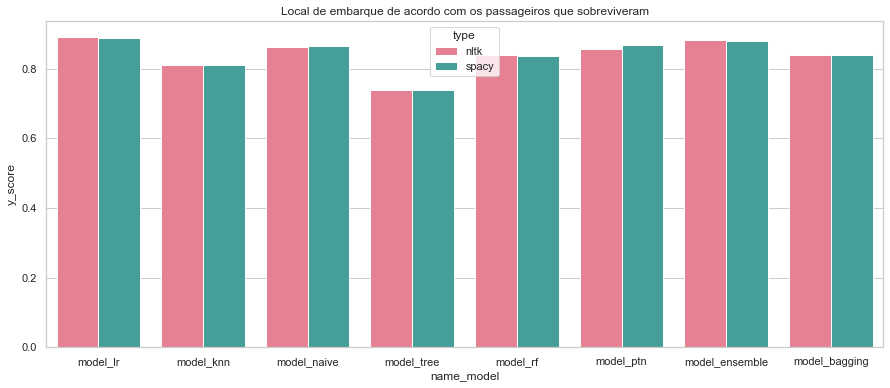

In [18]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,6))
sns.barplot(x="name_model",y='y_score',data = df_score,hue='type',palette="husl")
plt.title('Local de embarque de acordo com os passageiros que sobreviveram') 
plt.show()

OBS: Pode-se notar que não ocorreu uma diferença nos resultados das predições com as duas bibliotecas de NLP, isso porque as duas bibliotecas possuem processos semelhantes. 

#### Matriz de Confusão

É interessante realizar uma analise dos falsos positivos e negativos e verdadeiros positivos e negativos. Esses dados podem ser analisados utilizando as matrizes de confusão. Onde o 0 representa o sentimento negativo e o 1 o sentimento positivo. 

In [144]:
def matrix_confusao(names_models,models,X_test,y_test,tipo):
    f, axes = plt.subplots(1, 8, figsize=(20, 5), sharey='row')

    for i, model,name in zip([0,1,2,3,4,5,6,7],models,names_models):
        y_pred = model.predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_pred)
        m_score = round(accuracy_score(y_test, y_pred)*100, 2)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        disp.ax_.set_title("{} {}%".format(name,m_score))
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, tipo, ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    f.colorbar(disp.im_, ax=axes)
    plt.show()


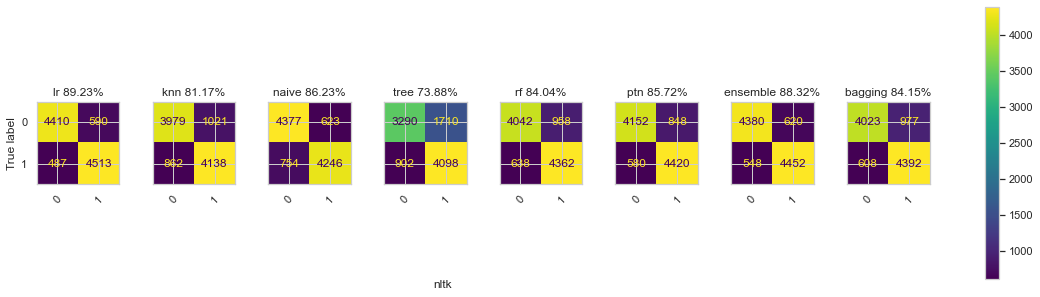

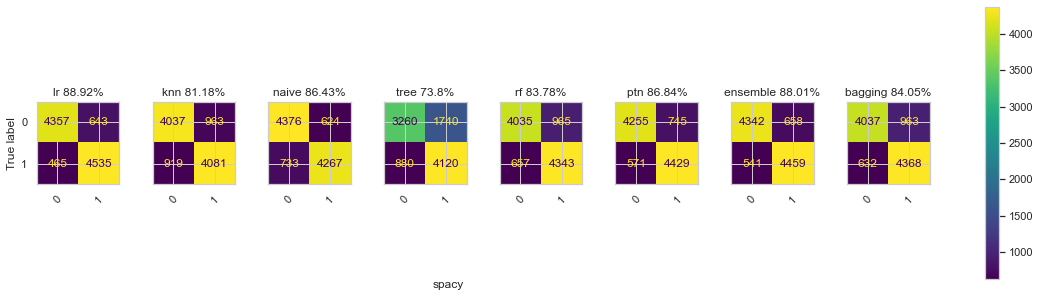

In [146]:
names_models = ["lr", "knn",  "naive" ,"tree", "rf" ,"ptn" ,"ensemble", "bagging"]
matrix_confusao(names_models,models_nltk,c_nltk.X_test,c_nltk.y_test,'nltk')
matrix_confusao(names_models,models_spacy,c_spacy.X_test,c_spacy.y_test,'spacy')

#### Word Cloud

As word clouds permitem analisar as palavras com mais frequencia dentro de um corpus.

In [151]:
data = pd.read_csv("dataset/df_processado_atual.csv")

In [154]:
data_neg = data.query('sentiment=="neg"')
data_pos = data.query('sentiment=="pos"')

In [169]:
def wcloud(texts,title):
    all_word = ' '.join([text for text in texts])
    wordcloud = WordCloud().generate(all_word)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

Word Cloud do texto processado com nltk.

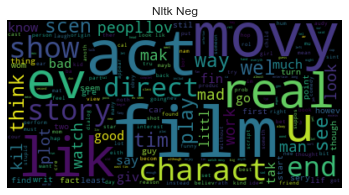

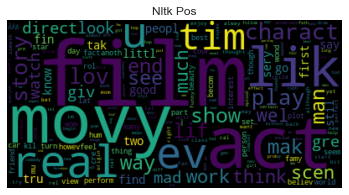

In [170]:
wcloud(data_neg.text_processed_nltk,"Nltk Neg")
wcloud(data_pos.text_processed_nltk,"Nltk Pos")

Word Cloud do texto processado com o spacy.

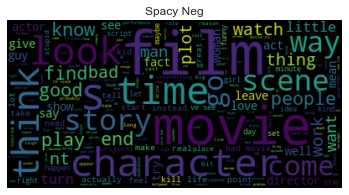

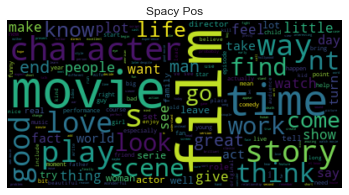

In [171]:
wcloud(data_neg.text_processed_spacy,"Spacy Neg")
wcloud(data_pos.text_processed_spacy,"Spacy Pos")